# Thrombectomy

## Aims

* Compare thrombectomy use at neuroscience centres v.s. non-neuroscience centres

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'

    raw_path = './../data/'
    hospitals_filename = 'stroke_hospitals_2022.csv'

    notebook = '01'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
hospitals = pd.read_csv(os.path.join(paths.raw_path,
                                     paths.hospitals_filename))

## Neuroscience centres

You can see that several patients are registered as being at a hospital that does not offer thrombectomy, but are marked as having received it.

ArrivalToThrombectomyTime should be time from arrival at first hospital, to thrombectomy at second hospital, if there is a transfer.

Issue: It is not fair to analyse thrombectomy times by hospital when this may have included travel time between hospitals, and reflect times of processes at both hospitals.

Caveats:
* Dataset on whether hospitals offer thrombectomy may be out of date (so may or may not offer it each year, contrary to our records - and will offer in some years and not in others - e.g. James Cook Hospital introduced it in 2021)
* Some hospitals don't offer thrombectomy 24/7, so may appear to have received it at one hospital when it was actually another (e.g. James Cook Hospital offer it Monday to Friday)
* Only know hospital they first arrived to - not the hospital they were transferred to (if transferred)

SSNAP data would have information on whether they were transferred or directly admitted for thrombectomy, but we do not have that information in our extract.

Abbreviations: IVT (intravenous thrombolysis), MT (mechnical thrombectomy), MSU (mobile stroke unit)

### Number of patients
Our file "hospitals_2022.csv" contains some information on each hospital, including whether they are a **neuroscience centre**. We expect these hospitals to be providing thrombectomy. However, we know that someones non-neuroscience centres provide thrombectomy (when they are maybe not supposed to be - e.g. not funded to do that) and that some neuroscience centres may sometimes not really provide thrombectomy.

**Why are there 25 neuroscience centres?** We have included Cardiff as a neuroscience centre - Wales don't use the same categorisation, but it is the only centre that provides thrombectomy in Wales, so if we were to apply England's classification system, we would say that it were a neuroscience centre.

Consider:
* Caveats above
* Size of hospital impacts number of patients (could look at proportion)
* Number of years in dataset will also impact number (could look at yearly average)

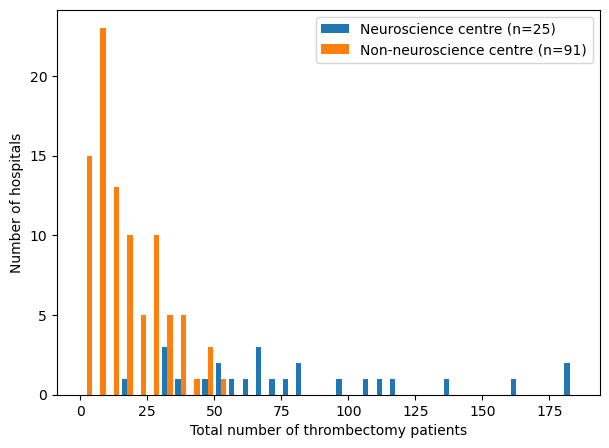

In [4]:
# Counts of patients at each hospital who received thrombectomy
data_mt_counts = (data.loc[data['thrombectomy'] == 1, 'stroke_team']
                  .value_counts()
                  .rename_axis('SSNAP name')
                  .reset_index(name='thrombectomy'))

# Record of whether hospitals offer thrombectomy and combine
hospitals_mt_available = hospitals[['SSNAP name', 'Neuroscience']]
mt_use = data_mt_counts.merge(hospitals_mt_available, on='SSNAP name')

# Count number of neuroscience centres v.s. non (to label plot)
n_neuro_str = (mt_use['Neuroscience'] == 1).sum().astype(str)
n_non_str = (mt_use['Neuroscience'] == 0).sum().astype(str)

# Create plot showing difference in use
offer = mt_use.loc[mt_use['Neuroscience'] == 1, 'thrombectomy']
dont_offer = mt_use.loc[mt_use['Neuroscience'] == 0, 'thrombectomy']

bins = np.arange(start=0, stop=mt_use['thrombectomy'].max()+5, step=5)

fig, ax = plt.subplots(figsize=(7, 5))

plt.hist([offer, dont_offer],
         bins=bins,
         label=['Neuroscience centre (n=' + n_neuro_str + ')',
                'Non-neuroscience centre (n=' + n_non_str + ')'])
plt.xlabel('Total number of thrombectomy patients')
plt.ylabel('Number of hospitals')
plt.legend(loc='upper right')
plt.show()

Expect a difference of 2 apx. hours due to transfer time...

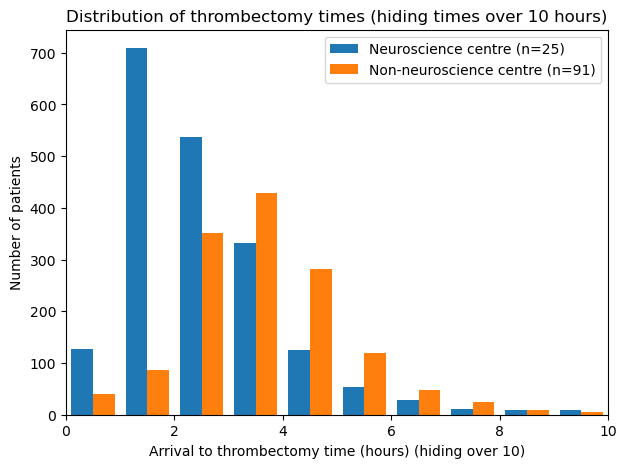

,count,mean,std,min,25%,50%,75%,max
Neuroscience,,,,,,,,
0,1457.0,4.21,3.26,0.03,2.75,3.57,4.60,33.08
1,2027.0,3.16,3.73,0.13,1.53,2.28,3.36,45.65


In [5]:
# Present difference in arrival to thrombectomy times, depending on whether
# hospital they are marked as being at offers MT

# Extract times of patients who received thrombectomy and add time in hours
data_mt_times = data[['stroke_team', 'arrival_to_thrombectomy_time']].dropna()
data_mt_times['time_hours'] = data_mt_times['arrival_to_thrombectomy_time']/60

# Combine with whether hospital is a neuroscience centre
mt_times = data_mt_times.merge(hospitals_mt_available,
                               left_on='stroke_team', right_on='SSNAP name')

# Plot difference in times
offer = mt_times.loc[
    mt_times['Neuroscience'] == 1, 'time_hours']
dont_offer = mt_times.loc[
    mt_times['Neuroscience'] == 0, 'time_hours']

bins = np.arange(start=0,
                 stop=mt_times['time_hours'].max()+1,
                 step=1)

fig, ax = plt.subplots(figsize=(7, 5))

plt.hist([offer, dont_offer],
         bins=bins,
         label=['Neuroscience centre (n=' + n_neuro_str + ')',
                'Non-neuroscience centre (n=' + n_non_str + ')'])
plt.title('Distribution of thrombectomy times (hiding times over 10 hours)')
plt.xlabel('Arrival to thrombectomy time (hours) (hiding over 10)')
plt.ylabel('Number of patients')
plt.legend(loc='upper right')
plt.xlim([0, 10])
plt.show()

display(round(mt_times.groupby(by='Neuroscience')['time_hours'].describe(), 2))